# Modèles
Ce script a pour but de développer les modèles de prédiction de churn des donateurs réguliers de l'ONG.
On dispose des données traitées dans le script Feat_Eng_2.

#### Importation des libraires

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
plt.style.use('ggplot')

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# modeles
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
# selection de modeles
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
# métriques d'évaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#### Chargement des données

In [157]:
# Chemin vers le répertoire contenant les données
PATH_DATA = "../data"

In [158]:
def read_data(data_filepath):
    """
    Lit les données du modèle sauvées via le deuxième script de feature engineering
    """
    data = pd.read_csv(os.path.join(data_filepath, 'data_modeles.csv'))
    data = data.drop(['ID_CONTACT'], axis=1)
    return data

data = read_data(PATH_DATA)
data.head()

,CHURN,MEAN_PA,STD_PA,MEAN_OCC,STD_OCC,MEAN_EVENT,STD_EVENT,TYPE_CONTACT,TRANCHE_AGE,ADRESSE_POSTALE,...,TELEPHONE,OPTIN,STOP_TEL,STOP_MAILING,STOP_GENERAL,CANAL_ACQUISITION_AGG,RATIO_CLICK,RATIO_OPEN,MEAN_3LAST,NB_3LAST
0,0,9.000000,0.000000,0.0,0.0,0.0,0.0,PHYSIQUE,25-45,1.0,...,1.0,1.0,0.0,0.0,0.0,Street,0.000000,0.000000,9.0,3
1,0,11.152542,0.996780,0.0,0.0,0.0,0.0,PHYSIQUE,45-65,1.0,...,1.0,1.0,1.0,0.0,0.0,Street,0.009259,0.240741,12.0,3
2,0,10.000000,0.000000,0.0,0.0,0.0,0.0,PHYSIQUE,45-65,1.0,...,1.0,1.0,0.0,0.0,0.0,Street,0.009259,0.546296,10.0,3
3,0,11.152542,0.996780,0.0,0.0,0.0,0.0,PHYSIQUE,25-45,1.0,...,1.0,1.0,0.0,0.0,0.0,Street,0.000000,0.057143,12.0,3
4,0,10.932203,1.127469,0.0,0.0,0.0,0.0,PHYSIQUE,25-45,1.0,...,1.0,1.0,0.0,0.0,0.0,Street,0.000000,0.027523,13.0,3


### Analyses des features

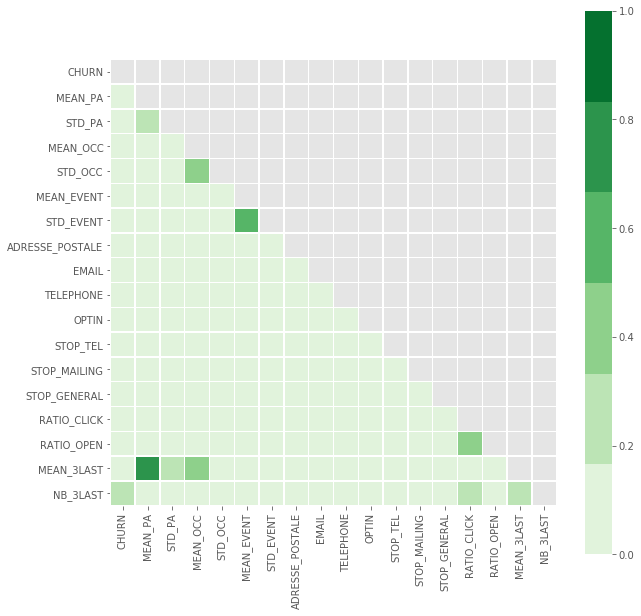

In [159]:
def display_corr(data):
    """Affichage de la matrice de corrélation de data"""
    corr = data.corr().abs()  # calcul de la matrice de covariance
    plt.figure(figsize=(10, 10))
    mask = np.zeros_like(corr, dtype=np.bool) # On génère un masque pour cacher le triangle sup de la matrice
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.color_palette("Greens")
    sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5)
    
display_corr(data)

In [160]:
def encode_cat_values(data, reset_index=True):
    """
    Encodage des variables catégoriques
    """
    cat_cols = data.select_dtypes(include='object').columns
    if reset_index:
        data.reset_index(drop=True, inplace=True)
    for col in cat_cols:
        col_vals = np.array(data[col])  # on récupère les valeurs
        val2enc = col_vals.reshape(len(col_vals), 1)  # on modifie la taille pour passer l'encodeur
        ohe = OneHotEncoder(sparse=False)
        newval = ohe.fit_transform(val2enc)
        name_cols = list(map(lambda x: col + "_" + x, ohe.categories_[0]))  # noms des nouvelles colonnes
        newdf = pd.DataFrame(newval[:,:-1], columns=name_cols[:-1]) 
        data = pd.concat([data.drop([col], axis=1), newdf], axis=1)  # on supprime l'ancienne feature
    return data

data = encode_cat_values(data)

In [161]:
def split_train_test(data):
    """
    Split les données en dataset de train et dataset de test
    """
    data_train, data_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=123)
    y_train = data_train.pop('CHURN')
    y_test = data_test.pop('CHURN')
    print('Taille train set : {}'.format(len(data_train)))
    print('Taille test set : {}'.format(len(data_test)))
    return data_train, y_train, data_test, y_test

x_train, y_train, x_test, y_test = split_train_test(data)

NameError: name 'test_data' is not defined

In [141]:
def scaling(data):
    """
    Scale les données
    """
    col_name = data.columns

    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data, columns=col_name)
    return data

x_train = scaling(x_train)
x_test = scaling(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Entrainement de modèles

In [89]:
### TEEEST

# Comparaison entre Support Vector Machine, LogisticRegression et XGBoost
RegLog = LogisticRegression()
RandFor = RandomForestClassifier()
XGB = XGBClassifier()

# Cross-validation KFold : 5 partitions indépendantes et aléatoires
kf = KFold(n_splits=5, shuffle=True)

# On fit le modèle sur les différentes partitions et on calcule chaque score
reg_score = cross_val_score(RegLog, x_train, y_train, cv=kf, scoring='roc_auc').mean()
rand_score = cross_val_score(RandFor, x_train, y_train, cv=kf, scoring='roc_auc').mean()
xgb_score = cross_val_score(XGB, x_train, y_train, cv=kf, scoring='roc_auc').mean()

# Affichage du score pour chaque modèle
print("AUC Regression Logistique : {}".format(round(reg_score, 4)))
print("AUC Random Forest : {}".format(round(rand_score, 4)))
print("AUC XGBoost : {}".format(round(xgb_score, 4)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

AUC Regression Logistique : 0.7682
AUC SVC : 0.6664
AUC Random Forest : 0.7027
AUC XGBoost : 0.8186


In [90]:
# Cross-validation KFold en 5 partitions indépendantes et aléatoires
kf = KFold(n_splits=5, shuffle=True)

In [93]:
# Amélioration de la régression logistique

RegLog = LogisticRegression()

param_grid = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100], 
    "penalty" : ["l1","l2"]
    }

logreg_cv = GridSearchCV(RegLog, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
logreg_cv.fit(x_train, y_train)
params_opt = logreg_cv.best_params_
score_opt = logreg_cv.best_score_

print("params Regression Logistique optimisés : {}".format(params_opt))
print("score optimisé : {}".format(score_opt))

# {'C': 0.1, 'penalty': 'l2'}

params Regression Logistique optimisés : {'C': 0.1, 'penalty': 'l2'}
score optimisé : 0.777893610050457


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [144]:
try:
    RegLog_opt = LogisticRegression(C=params_opt['C'], 
                                    penalty=params_opt['penalty'])
except:
    RegLog_opt = LogisticRegression(C=0.1, 
                                    penalty='l1')

In [112]:
# Amélioration du RandomForest

RandFor = RandomForestClassifier(n_estimators=100)

param_grid = {
    "max_depth": [3, 5, None],
    'max_features': ['auto', 'sqrt'],
    "min_samples_split": [2, 5],
    "criterion": ["gini", "entropy"],
    "n_estimators": [100, 200, 300]
     }

rand_gs = GridSearchCV(RandFor, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
rand_gs.fit(x_train, y_train)
params_opt = rand_gs.best_params_
score_opt = rand_gs.best_score_

print("params Random Forest optimisés : {}".format(params_opt))
print("score optimisé : {}".format(score_opt))

# {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 
#  'min_samples_split': 2, 'n_estimators': 200}

params Random Forest optimisés : {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}
score optimisé : 0.8100557951761086


In [145]:
try:
    RandFor_opt = RandomForestClassifier(n_estimators=params_opt['n_estimators'], 
                                         max_depth=params_opt['max_depth'], 
                                         max_features=params_opt['max_features'],
                                         min_samples_split=params_opt['min_samples_split'],
                                         criterion=params_opt['criterion'])
except:
    RandFor_opt = RandomForestClassifier(n_estimators=200, 
                                         max_depth=5, 
                                         max_features='auto',
                                         min_samples_split=2,
                                         criterion='entropy')

In [116]:
# Amélioration du XGBoost 
    
XGB = XGBClassifier()    

param_grid = {
    'max_depth': [4],
    'min_child_weight': [1],
    'gamma': [5, 8, 10],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.6, 0.7],
    'n_estimators': [100, 200, 500]
    }

xgb_gs = GridSearchCV(XGB, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
xgb_gs.fit(x_train, y_train)
params_opt = xgb_gs.best_params_
score_opt = xgb_gs.best_score_

print("params XGBoost optimisés : {}".format(params_opt))
print("score optimisé : {}".format(score_opt))

# params optimisés : {'gamma': 2, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8}

params XGBoost optimisés : {'colsample_bytree': 0.7, 'gamma': 5, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
score optimisé : 0.8237897079416705


In [146]:
try:
    XGB_opt = XGBClassifier(n_estimators=params_opt['n_estimators'],
                            min_child_weight=params_opt['min_child_weight'], 
                            gamma=params_opt['gamma'], 
                            subsample=params_opt['subsample'],
                            max_depth=params_opt['max_depth'],
                            colsample_bytree=params_opt['colsample_bytree'])
except:
    XGB_opt = XGBClassifier(n_estimators=200,
                            min_child_weight=1, 
                            gamma=5, 
                            subsample=0.9,
                            max_depth=4,
                            colsample_bytree=0.7)

In [195]:
# Définition du VotingClassifier
voting = VotingClassifier(estimators=[('rl', RegLog_opt),('rf', RandFor_opt), ('xgb', XGB_opt)],
                          voting='soft', weights = [1, 1, 1], n_jobs=-1)
voting.fit(x_train, y_train)
print("Score cross-val: " + str(voting.score(x_test, y_test)))

Score cross-val: 0.9649122807017544


In [196]:
probas = voting.predict_proba(x_test)
probas_churn = list(map(lambda el : el[1], probas))
result_contact = pd.DataFrame({'PROBA_CHURN' : probas_churn, 
                               'CHURN' : y_test})
result_contact.head()

,PROBA_CHURN,CHURN
9159,0.015667,0
10,0.010174,0
1504,0.018616,0
6681,0.020350,0
5414,0.021641,0


In [202]:
# Evaluation des résultats pour un seuil fixé

SEUIL = 0.036
result_contact['PREDICT_CHURN'] = result_contact['PROBA_CHURN'].map(lambda proba : 1 if proba > SEUIL else 0)

auc_score = roc_auc_score(result_contact['CHURN'], result_contact['PREDICT_CHURN'])
prec_score = precision_score(result_contact['CHURN'], result_contact['PREDICT_CHURN'])
rec_score = recall_score(result_contact['CHURN'], result_contact['PREDICT_CHURN'])

print("AUC test set : {}".format(auc_score))
print("Precision test set : {}".format(prec_score))
print("Recall test set : {}".format(rec_score))

AUC test set : 0.8032634032634033
Precision test set : 0.226890756302521
Recall test set : 0.6923076923076923
Balanced Acc : 0.8032634032634032


Text(0,0.5,'Feature Importance Score')

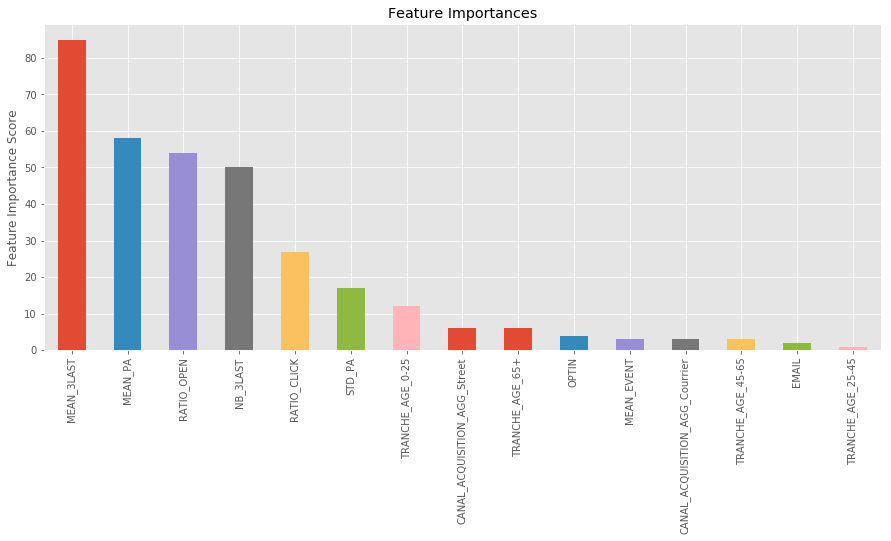

In [199]:
XGB_opt.fit(x_train, y_train)

feat_imp = pd.Series(XGB_opt.get_booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(15, 6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')